In [477]:
import seaborn as sns
import itertools as it
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv, to_datetime
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn import preprocessing
from scipy import stats
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [478]:

filename='disk1.txt'

with open(filename,'r') as f:
    for key,group in it.groupby(f,lambda line: line.startswith('[0-9]{4}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1]) (2[0-3]|[01][0-9]):[0-5][0-9]')):
        if not key:
            group = list(group)
            print(group)

['2005-10-30 10:46\n', 'cpu1 cpu2 cpu3\n', '1000 3000 2167\n', '\n', '\n', '2005-10-30 10:52\n', 'cpu1 cpu2 cpu3\n', '1000 3000 2167\n', '\n', '\n', '2005-10-30 11:03\n', 'cpu1 cpu2 cpu3\n', '1000 3000 2167\n', '\n', '\n', '2005-10-30 11:12\n', 'cpu1 cpu2 cpu3\n', '1000 3000 2167\n', '\n', '\n', '2005-10-30 11:25\n', 'cpu1 cpu2 cpu3\n', '1000 3000 2167\n', '\n', '\n', '2005-10-30 11:35\n', 'cpu1 cpu2 cpu3\n', '1000 3000 2167\n', '\n', '\n', '2005-10-30 11:45\n', 'cpu1 cpu2 cpu3\n', '1000 3000 2167\n', '\n', '2005-10-30 11:55\n', 'cpu1 cpu2 cpu3\n', '1000 3000 2167\n', '\n', '2005-10-30 12:05\n', 'cpu1 cpu2 cpu3\n', '1000 3000 2167\n', '\n']


In [479]:

#with open("disk1.txt") as f:
#    my_list = f.readlines()
#print(my_list)

def process_string(my_list):
    #print(my_list)
    #Getting all the index of dates,which will be further used for slicing
    index_list=[]
    for item in range(0,len(my_list)):
        res= re.search(r'[0-9]{4}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1]) (2[0-3]|[01][0-9]):[0-5][0-9]',my_list[item])
        if res:
            #print(item)
            index_list.append(item)
    #print(index_list)

    #slicing the index
    data_list=[]
    for item in range(0,len(index_list)-1):
        data_list.append(my_list[index_list[item]:index_list[item+1]])
    #print(data_list)

    #Creating a dataframe
    cleaned_data_list=[]
    for li in data_list:
        for item in range(2,len(li)):
            temp_li=[]
            temp_li.append(li[0].strip("\n"))
            if li[item] != '':
                temp_arr=li[item].strip("\n").split(" ")
                temp_li.append(temp_arr[0])
                temp_li.append(temp_arr[1])
                temp_li.append(temp_arr[2])
                cleaned_data_list.append(temp_li)
    return cleaned_data_list

In [480]:
def process_data(string):
    arr=string.split('\n')
    return process_string(arr)
    #print(arr)

def read_in_chunks(file_object, chunk_size=100):
    """Lazy function (generator) to read a file piece by piece.
    Default chunk size: 1k."""
    while True:
        data = file_object.read(chunk_size)
        if not data:
            break
        yield data

append_str=""
with open('disk1.txt') as f:
    for piece in read_in_chunks(f):
        append_str+=piece
print(process_data(append_str))
cleaned_data_list=process_data(append_str)

[['2005-10-30 10:46', '1000', '3000', '2167'], ['2005-10-30 10:52', '1000', '3000', '2167'], ['2005-10-30 11:03', '1000', '3000', '2167'], ['2005-10-30 11:12', '1000', '3000', '2167'], ['2005-10-30 11:25', '1000', '3000', '2167'], ['2005-10-30 11:35', '1000', '3000', '2167'], ['2005-10-30 11:45', '1000', '3000', '2167'], ['2005-10-30 11:55', '1000', '3000', '2167']]


In [481]:

df = pd.DataFrame(cleaned_data_list, columns = ['Date','cpu1', 'cpu2','cpu3'])
#df=df.set_index('Date')
#Impute white spaces with nan values
df=df.replace(r'^\s*$', np.nan, regex=True)
convert_dict = {'cpu1': float, 
                'cpu2': float,
                'cpu3': float
               } 
  
df = df.astype(convert_dict) 
df["Date"] = pd.to_datetime(df["Date"])
df.head()

,Date,cpu1,cpu2,cpu3
0,2005-10-30 10:46:00,1000.0,3000.0,2167.0
1,2005-10-30 10:52:00,1000.0,3000.0,2167.0
2,2005-10-30 11:03:00,1000.0,3000.0,2167.0
3,2005-10-30 11:12:00,1000.0,3000.0,2167.0
4,2005-10-30 11:25:00,1000.0,3000.0,2167.0


In [482]:
df_copy=df.copy()
df_copy['cpu1_rolling_mean']=df_copy['cpu1'].astype(float).rolling(2).mean()
df_copy.head()

,Date,cpu1,cpu2,cpu3,cpu1_rolling_mean
0,2005-10-30 10:46:00,1000.0,3000.0,2167.0,NaN
1,2005-10-30 10:52:00,1000.0,3000.0,2167.0,1000.0
2,2005-10-30 11:03:00,1000.0,3000.0,2167.0,1000.0
3,2005-10-30 11:12:00,1000.0,3000.0,2167.0,1000.0
4,2005-10-30 11:25:00,1000.0,3000.0,2167.0,1000.0


In [483]:
df2=pd.read_excel('pivot.xlsx',skiprows=2)
df2=df2.set_index('date')
flattened = pd.DataFrame(df2.to_records())
flattened.columns=["Date","deposit","I0 cpu0","I0 cpu1","I0 cpu2"]
#flattened=flattened.set_index('date')
flattened=flattened.replace(r'^\s*$', np.nan, regex=True)
convert_dict = {
                'deposit': float,
                'I0 cpu0': float, 
                'I0 cpu1': float,
                'I0 cpu2': float
               } 
  
flattened= flattened.astype(convert_dict) 
flattened["Date"] = pd.to_datetime(flattened["Date"])
flattened.head()

,Date,deposit,I0 cpu0,I0 cpu1,I0 cpu2
0,2005-10-30 10:45:03,6220140.0,56143.0,75.0,34.0
1,2005-10-30 10:54:10,62240.0,543.0,50.0,82.0
2,2005-10-30 11:03:05,60140.0,345.0,85.0,92.0
3,2005-10-30 11:14:10,62201.0,430.0,95.0,12.0
4,2005-10-30 11:25:18,1400.0,450.0,35.0,52.0


# Data Exploration Step

In [484]:
#missing value detection 
df.head()

,Date,cpu1,cpu2,cpu3
0,2005-10-30 10:46:00,1000.0,3000.0,2167.0
1,2005-10-30 10:52:00,1000.0,3000.0,2167.0
2,2005-10-30 11:03:00,1000.0,3000.0,2167.0
3,2005-10-30 11:12:00,1000.0,3000.0,2167.0
4,2005-10-30 11:25:00,1000.0,3000.0,2167.0


In [485]:
flattened.head()

,Date,deposit,I0 cpu0,I0 cpu1,I0 cpu2
0,2005-10-30 10:45:03,6220140.0,56143.0,75.0,34.0
1,2005-10-30 10:54:10,62240.0,543.0,50.0,82.0
2,2005-10-30 11:03:05,60140.0,345.0,85.0,92.0
3,2005-10-30 11:14:10,62201.0,430.0,95.0,12.0
4,2005-10-30 11:25:18,1400.0,450.0,35.0,52.0


In [486]:
df.describe()

,cpu1,cpu2,cpu3
count,8.0,8.0,8.0
mean,1000.0,3000.0,2167.0
std,0.0,0.0,0.0
min,1000.0,3000.0,2167.0
25%,1000.0,3000.0,2167.0
50%,1000.0,3000.0,2167.0
75%,1000.0,3000.0,2167.0
max,1000.0,3000.0,2167.0


In [487]:
flattened.describe()

,deposit,I0 cpu0,I0 cpu1,I0 cpu2
count,5.000000e+00,5.00000,5.000000,5.000000
mean,1.281224e+06,11582.20000,68.000000,54.400000
std,2.761061e+06,24910.34393,24.899799,33.148152
min,1.400000e+03,345.00000,35.000000,12.000000
25%,6.014000e+04,430.00000,50.000000,34.000000
50%,6.220100e+04,450.00000,75.000000,52.000000
75%,6.224000e+04,543.00000,85.000000,82.000000
max,6.220140e+06,56143.00000,95.000000,92.000000


In [488]:
#Merging these two tables on the basis of timestamp
#Interval matching
threshold = 5
threshold_ns = threshold * 60 * 1e9

# compute "interval" to which each session belongs
df['Date'] = to_datetime(np.round(df['Date'].astype(np.int64) / threshold_ns) * threshold_ns)
flattened['Date'] = to_datetime(np.round(flattened['Date'].astype(np.int64) / threshold_ns) * threshold_ns)

# join
cols = ['Date']
df_new=pd.concat([df,flattened],axis=0,ignore_index=True)
df_new
## join
#cols = ['interval', 'employee_id', 'session_id']
#print df1.merge(df2, on=cols, how='outer')[cols]

C:\Users\akum232\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


,Date,I0 cpu0,I0 cpu1,I0 cpu2,cpu1,cpu2,cpu3,deposit
0,2005-10-30 10:45:00,NaN,NaN,NaN,1000.0,3000.0,2167.0,NaN
1,2005-10-30 10:50:00,NaN,NaN,NaN,1000.0,3000.0,2167.0,NaN
2,2005-10-30 11:05:00,NaN,NaN,NaN,1000.0,3000.0,2167.0,NaN
3,2005-10-30 11:10:00,NaN,NaN,NaN,1000.0,3000.0,2167.0,NaN
4,2005-10-30 11:25:00,NaN,NaN,NaN,1000.0,3000.0,2167.0,NaN
5,2005-10-30 11:35:00,NaN,NaN,NaN,1000.0,3000.0,2167.0,NaN
6,2005-10-30 11:45:00,NaN,NaN,NaN,1000.0,3000.0,2167.0,NaN
7,2005-10-30 11:55:00,NaN,NaN,NaN,1000.0,3000.0,2167.0,NaN
8,2005-10-30 10:45:00,56143.0,75.0,34.0,NaN,NaN,NaN,6220140.0
9,2005-10-30 10:55:00,543.0,50.0,82.0,NaN,NaN,NaN,62240.0


In [489]:
#Null Checks
#check which columns have missing values
print(df.columns[df.isnull().any()])
miss = df.isnull().sum()/len(df)
miss=miss[miss>0]
miss.sort_values(inplace=True)
miss

Index([], dtype='object')


Series([], dtype: float64)

0


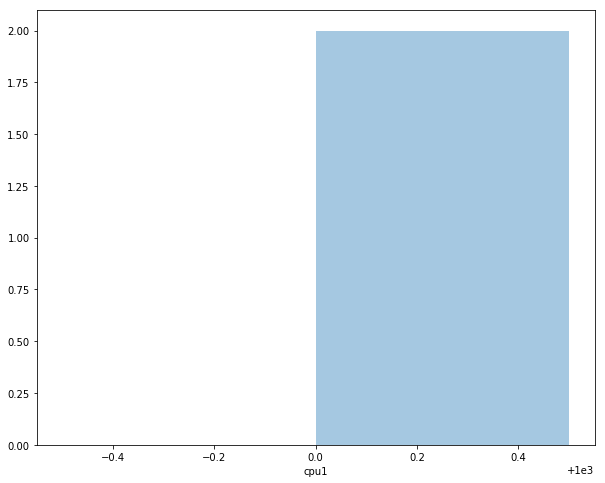

In [490]:
#check the distribution
sns.distplot(df['cpu1'].astype(float))
print(df['cpu1'].astype(float).skew())

('Skewness is', 0)


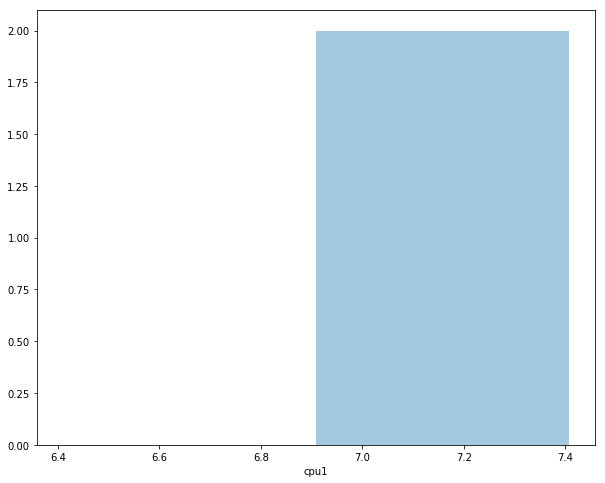

In [491]:
target = np.log(df['cpu1'].astype(float))
print ('Skewness is', target.skew())
sns.distplot(target)

In [492]:
corr = df.corr()
#sns.heatmap(corr)
corr

,cpu1,cpu2,cpu3
cpu1,NaN,NaN,NaN
cpu2,NaN,NaN,NaN
cpu3,NaN,NaN,NaN


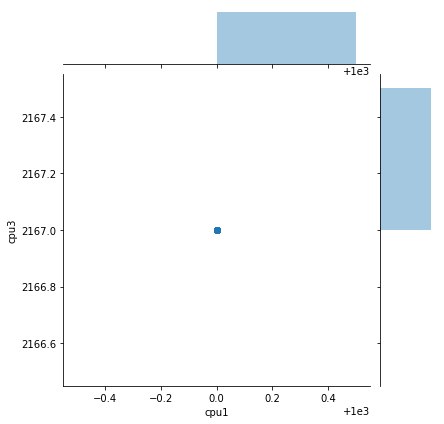

In [493]:
#For checking correlation
sns.jointplot(x=df['cpu1'], y=df['cpu3'])

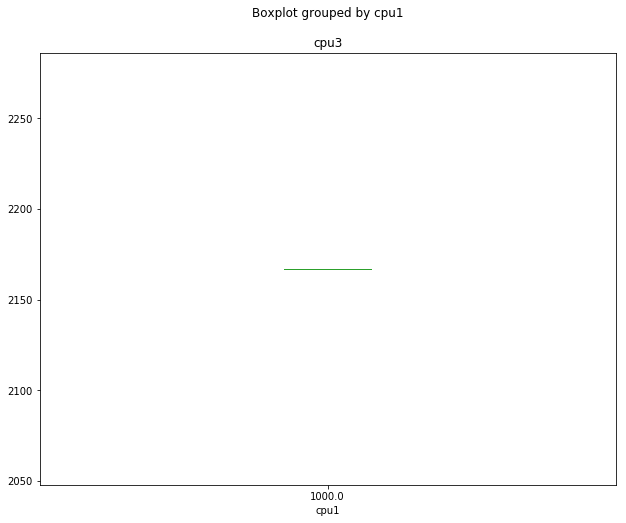

In [494]:
#box plot for outlier detection
df.boxplot(by = 'cpu1', column = 'cpu3', grid=False) 

In [495]:
#Removing outliers
print("before shape is ",df.shape)
df.drop(df[df['cpu1'] < 100].index, inplace=True)
print("After shape is ",df.shape)
df.head()

('before shape is ', (8, 4))
('After shape is ', (8, 4))


,Date,cpu1,cpu2,cpu3
0,2005-10-30 10:45:00,1000.0,3000.0,2167.0
1,2005-10-30 10:50:00,1000.0,3000.0,2167.0
2,2005-10-30 11:05:00,1000.0,3000.0,2167.0
3,2005-10-30 11:10:00,1000.0,3000.0,2167.0
4,2005-10-30 11:25:00,1000.0,3000.0,2167.0


In [498]:
#To check which column has outlier
#df.set_index('Date',inplace=True)
cols = list(df.columns)
cols.remove('Date')
print(cols)
for col in cols:
    print("col is ",col)
    col_zscore = col + '_zscore'
    df[col_zscore] = (df[col] - df[col].mean())/df[col].std(ddof=0)
df.head()

['cpu1', 'cpu2', 'cpu3']
('col is ', 'cpu1')
('col is ', 'cpu2')
('col is ', 'cpu3')


,Date,cpu1,cpu2,cpu3,cpu1_zscore,cpu2_zscore,cpu3_zscore
0,2005-10-30 10:45:00,1000.0,3000.0,2167.0,NaN,NaN,NaN
1,2005-10-30 10:50:00,1000.0,3000.0,2167.0,NaN,NaN,NaN
2,2005-10-30 11:05:00,1000.0,3000.0,2167.0,NaN,NaN,NaN
3,2005-10-30 11:10:00,1000.0,3000.0,2167.0,NaN,NaN,NaN
4,2005-10-30 11:25:00,1000.0,3000.0,2167.0,NaN,NaN,NaN


In [410]:
#Replacing null values with median
df["cpu2"]=df["cpu2"].fillna(df["cpu2"].median())
df.head()

,Date,cpu1,cpu2,cpu3
0,2005-10-30 10:45:00,1000.0,3000.0,2167.0
1,2005-10-30 10:50:00,1000.0,3000.0,2167.0
2,2005-10-30 11:05:00,1000.0,3000.0,2167.0
3,2005-10-30 11:10:00,1000.0,3000.0,2167.0
4,2005-10-30 11:25:00,1000.0,3000.0,2167.0


In [411]:
#Form one data frame grouping by similar timestamp
df_one=df_new.copy()
df_one['I0 cpu0']=df_one['I0 cpu0'].fillna(0)
sums=df_one.groupby('Date')['I0 cpu0'].sum()
df_one['I0 cpu0']=df_one['Date'].map(sums)
df_one['I0 cpu1']=df_one['Date'].map(df_one.groupby('Date')['I0 cpu1'].sum())
df_one['I0 cpu2']=df_one['Date'].map(df_one.groupby('Date')['I0 cpu2'].sum())
df_one['cpu1']=df_one['Date'].map(df_one.groupby('Date')['cpu1'].sum())
df_one['cpu2']=df_one['Date'].map(df_one.groupby('Date')['cpu2'].sum())
df_one['cpu3']=df_one['Date'].map(df_one.groupby('Date')['cpu3'].sum())
df_one['deposit']=df_one['Date'].map(df_one.groupby('Date')['deposit'].sum())
df_one=df_one.drop_duplicates(subset=['Date'])
df_one.sort_values('Date')

,Date,I0 cpu0,I0 cpu1,I0 cpu2,cpu1,cpu2,cpu3,deposit
0,2005-10-30 10:45:00,56143.0,75.0,34.0,1000.0,3000.0,2167.0,6220140.0
1,2005-10-30 10:50:00,0.0,0.0,0.0,1000.0,3000.0,2167.0,0.0
9,2005-10-30 10:55:00,543.0,50.0,82.0,0.0,0.0,0.0,62240.0
2,2005-10-30 11:05:00,345.0,85.0,92.0,1000.0,3000.0,2167.0,60140.0
3,2005-10-30 11:10:00,0.0,0.0,0.0,1000.0,3000.0,2167.0,0.0
11,2005-10-30 11:15:00,430.0,95.0,12.0,0.0,0.0,0.0,62201.0
4,2005-10-30 11:25:00,450.0,35.0,52.0,1000.0,3000.0,2167.0,1400.0
5,2005-10-30 11:35:00,0.0,0.0,0.0,1000.0,3000.0,2167.0,0.0
6,2005-10-30 11:45:00,0.0,0.0,0.0,1000.0,3000.0,2167.0,0.0
7,2005-10-30 11:55:00,0.0,0.0,0.0,1000.0,3000.0,2167.0,0.0


In [412]:
#DataFrame Example
import pandas as pd
df = pd.DataFrame({'X':[78,85,96,80,86], 'Y':[84,94,89,83,86],'Z':[86,97,96,72,83]});
print(df)

    X   Y   Z
0  78  84  86
1  85  94  97
2  96  89  96
3  80  83  72
4  86  86  83


In [413]:
#FInd the maximum in row
df_one[['Date','cpu1']][df_one['cpu1']==df_one['cpu1'].max()]

,Date,cpu1
0,2005-10-30 10:45:00,1000.0
1,2005-10-30 10:50:00,1000.0
2,2005-10-30 11:05:00,1000.0
3,2005-10-30 11:10:00,1000.0
4,2005-10-30 11:25:00,1000.0
5,2005-10-30 11:35:00,1000.0
6,2005-10-30 11:45:00,1000.0
7,2005-10-30 11:55:00,1000.0


In [414]:
df=pd.read_csv('Automobile_data.csv')
df.head()

,index,company,body-style,wheel-base,length,engine-type,num-of-cylinders,horsepower,average-mileage,price
0,0,alfa-romero,convertible,88.6,168.8,dohc,four,111,21,13495.0
1,1,alfa-romero,convertible,88.6,168.8,dohc,four,111,21,16500.0
2,2,alfa-romero,hatchback,94.5,171.2,ohcv,six,154,19,16500.0
3,3,audi,sedan,99.8,176.6,ohc,four,102,24,13950.0
4,4,audi,sedan,99.4,176.6,ohc,five,115,18,17450.0


In [415]:
#replace all "?,n.a" values with NaN 
df_copy=df.copy()
df_copy.replace(['?','n.a'],np.NaN)

,index,company,body-style,wheel-base,length,engine-type,num-of-cylinders,horsepower,average-mileage,price
0,0,alfa-romero,convertible,88.6,168.8,dohc,four,111,21,13495.0
1,1,alfa-romero,convertible,88.6,168.8,dohc,four,111,21,16500.0
2,2,alfa-romero,hatchback,94.5,171.2,ohcv,six,154,19,16500.0
3,3,audi,sedan,99.8,176.6,ohc,four,102,24,13950.0
4,4,audi,sedan,99.4,176.6,ohc,five,115,18,17450.0
5,5,audi,sedan,99.8,177.3,ohc,five,110,19,15250.0
6,6,audi,wagon,105.8,192.7,ohc,five,110,19,18920.0
7,9,bmw,sedan,101.2,176.8,ohc,four,101,23,16430.0
8,10,bmw,sedan,101.2,176.8,ohc,four,101,23,16925.0
9,11,bmw,sedan,101.2,176.8,ohc,six,121,21,20970.0


In [416]:
#get the max price
df_copy[['company','price']][df_copy.price==df_copy['price'].max()]

,company,price
35,mercedes-benz,45400.0


In [417]:
#print particular car details
x=df_copy.groupby('company')
toyota_df=x.get_group('toyota')
toyota_df

,index,company,body-style,wheel-base,length,engine-type,num-of-cylinders,horsepower,average-mileage,price
48,66,toyota,hatchback,95.7,158.7,ohc,four,62,35,5348.0
49,67,toyota,hatchback,95.7,158.7,ohc,four,62,31,6338.0
50,68,toyota,hatchback,95.7,158.7,ohc,four,62,31,6488.0
51,69,toyota,wagon,95.7,169.7,ohc,four,62,31,6918.0
52,70,toyota,wagon,95.7,169.7,ohc,four,62,27,7898.0
53,71,toyota,wagon,95.7,169.7,ohc,four,62,27,8778.0
54,79,toyota,wagon,104.5,187.8,dohc,six,156,19,15750.0


In [418]:
#count total cars per company
df_copy['company'].value_counts()

toyota           7
bmw              6
mazda            5
nissan           5
audi             4
mitsubishi       4
mercedes-benz    4
volkswagen       4
honda            3
chevrolet        3
alfa-romero      3
isuzu            3
porsche          3
jaguar           3
volvo            2
dodge            2
Name: company, dtype: int64

In [419]:
#highest price for each car
res=df_copy.groupby('company')['price'].max()
res

company
alfa-romero      16500.0
audi             18920.0
bmw              41315.0
chevrolet         6575.0
dodge             6377.0
honda            12945.0
isuzu             6785.0
jaguar           36000.0
mazda            18344.0
mercedes-benz    45400.0
mitsubishi        8189.0
nissan           13499.0
porsche          37028.0
toyota           15750.0
volkswagen        9995.0
volvo            13415.0
Name: price, dtype: float64

In [420]:
#average mileage for each car
df_copy.groupby('company')['average-mileage'].mean()

company
alfa-romero      20.333333
audi             20.000000
bmw              19.000000
chevrolet        41.000000
dodge            31.000000
honda            26.333333
isuzu            33.333333
jaguar           14.333333
mazda            28.000000
mercedes-benz    18.000000
mitsubishi       29.500000
nissan           31.400000
porsche          17.000000
toyota           28.714286
volkswagen       31.750000
volvo            23.000000
Name: average-mileage, dtype: float64

In [421]:
#sort all cars by price column
df_copy.sort_values('price',ascending=False).head()

,index,company,body-style,wheel-base,length,engine-type,num-of-cylinders,horsepower,average-mileage,price
35,47,mercedes-benz,hardtop,112.0,199.2,ohcv,eight,184,14,45400.0
11,14,bmw,sedan,103.5,193.8,ohc,six,182,16,41315.0
34,46,mercedes-benz,sedan,120.9,208.1,ohcv,eight,184,14,40960.0
46,62,porsche,convertible,89.5,168.9,ohcf,six,207,17,37028.0
12,15,bmw,sedan,110.0,197.0,ohc,six,182,15,36880.0


In [422]:
dict1={'Company': ['Ford', 'Mercedes', 'BMV', 'Audi'], 'Price': [23845, 171995, 135925 , 71400]}
df1=pd.DataFrame(dict1)
dict2={'Company': ['Toyota', 'Honda', 'Nissan', 'Mitsubishi '], 'Price': [29995, 23600, 61500 , 58900]}
df2=pd.DataFrame(dict2)
pd.concat([df1,df2],keys=["Germany","Japan"])

Company   Price
Germany 0         Ford   23845
        1     Mercedes  171995
        2          BMV  135925
        3         Audi   71400
Japan   0       Toyota   29995
        1        Honda   23600
        2       Nissan   61500
        3  Mitsubishi    58900

In [423]:
Car_Price = {'Company': ['Toyota', 'Honda', 'BMV', 'Audi'], 'Price': [23845, 17995, 135925 , 71400]}
car_Horsepower = {'Company': ['Toyota', 'Honda', 'BMV', 'Audi'], 'horsepower': [141, 80, 182 , 160]}
df1=pd.DataFrame(Car_Price)
df2=pd.DataFrame(car_Horsepower)
df3=pd.merge(df1,df2)
df3

,Company,Price,horsepower
0,Toyota,23845,141
1,Honda,17995,80
2,BMV,135925,182
3,Audi,71400,160


# TimeSeries Analysis

In [424]:
import pandas as pd

In [425]:
def read_file(fname):
    dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
    ts=pd.read_csv(fname,parse_dates=['Month'], index_col='Month',date_parser=dateparse)
    return ts

In [426]:
def plot_graph(ts):
    plt.plot(ts)

In [427]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

In [428]:
#Making timeseries Stationary
def eliminateTrend(ts):
    ts_log=np.log(ts)
    return ts_log

In [429]:
def movingAverage(ts):
    moving_avg = ts.rolling(12).mean()
    return moving_avg

In [430]:
def movingAverageDifference(ts_log,moving_avg):
    ts_log_moving_avg_diff = ts_log - moving_avg
    ts_log_moving_avg_diff.head(12)
    return ts_log_moving_avg_diff

In [431]:
def differencing(ts_log):
    ts_log_diff = ts_log - ts_log.shift()
    return ts_log_diff

In [432]:
def forecast_times_series(ts_log_diff):
    lag_acf = acf(ts_log_diff, nlags=20)
    lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')
    #Plot ACF: 
    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')
    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()

In [499]:
def AutoRegressiveModel(ts_log,ts_log_diff):
    model = ARIMA(ts_log, order=(2, 1, 0))  
    results_AR = model.fit(disp=-1)  
    plt.plot(ts_log_diff)
    plt.plot(results_AR.fittedvalues, color='red')
    plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

C:\Users\akum232\AppData\Local\Continuum\anaconda2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\akum232\AppData\Local\Continuum\anaconda2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


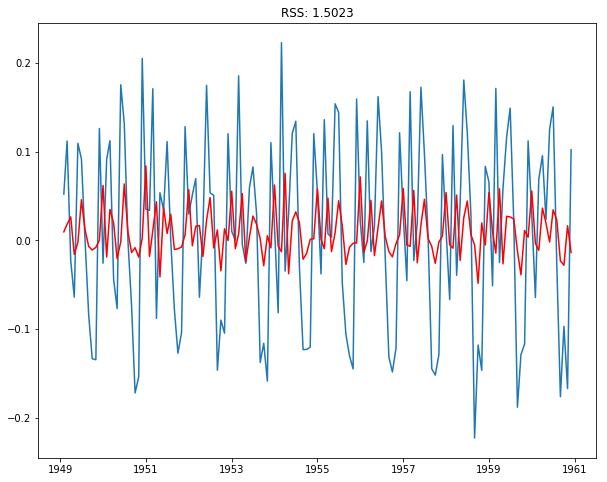

In [434]:
ts=read_file('AirPassengers.csv')
passsengers=ts["#Passengers"]
X = ts.values
#plot_graph(passsengers)
ts_log=eliminateTrend(passsengers)
moving_avg=movingAverage(ts_log)
#plot_graph(ts_log)
#plt.plot(moving_avg,color='red')
ts_log_moving_avg_diff=movingAverageDifference(ts_log,moving_avg)
ts_log_moving_avg_diff.dropna(inplace=True)
#test_stationarity(ts_log_moving_avg_diff)
ts_log_diff=differencing(ts_log)
#plot_graph(ts_log_diff)
ts_log_diff.dropna(inplace=True)
AutoRegressiveModel(ts_log,ts_log_diff)
size = len(X) - 7
train, test = X[0:size], X[size:]
history = [x for x in train]
predictions = list()
#test_stationarity(ts_log_diff)
#forecast_times_series(ts_log_diff)
ts.head()
#test_stationarity(passsengers)

In [435]:
def oddNumbers(limit):
    start =1
    while start < limit:
        yield start
        start+=2

for item in oddNumbers(10):
    print(item)

1
3
5
7
9


In [436]:
# importing the multiprocessing module 
import multiprocessing 

def print_cube(num): 
    """ 
    function to print cube of given num 
    """
    print("Cube: {}".format(num * num * num)) 

def print_square(num): 
    """ 
    function to print square of given num 
    """
    print("Square: {}".format(num * num)) 

if __name__ == "__main__": 
    # creating processes 
    p1 = multiprocessing.Process(target=print_square, args=(10, )) 
    p2 = multiprocessing.Process(target=print_cube, args=(10, )) 

    # starting process 1 
    p1.start() 
    # starting process 2 
    p2.start() 

    # wait until process 1 is finished 
    p1.join() 
    # wait until process 2 is finished 
    p2.join() 

    # both processes finished 
    print("Done!") 


Done!


# Pollution Data

In [437]:
def process_csv_file(arr):
    header=arr[0]
    lilist=[]
    for item in range(1,len(arr)-1):
            lilist.append(arr[item].split(","))
    #print(lilist)
    return lilist

In [438]:
def process_data(string):
    arr=string.split('\n')
    return process_csv_file(arr)
    #print(arr)

def read_in_chunks(file_object, chunk_size=1000):
    """Lazy function (generator) to read a file piece by piece.
    Default chunk size: 1k."""
    while True:
        data = file_object.read(chunk_size)
        if not data:
            break
        yield data

append_str=""
with open('pollution.csv') as f:
    for piece in read_in_chunks(f):
        append_str+=piece
#print(process_data(append_str))
cleaned_data_list=process_data(append_str)

In [439]:
df_pollution=pd.DataFrame(cleaned_data_list,columns=["No","year","month","day","hour","pm2.5","DEWP","TEMP","PRES","cbwd","Iws","Is","Ir"])
df_pollution['Date']=pd.to_datetime(df_pollution[['year', 'month', 'day', 'hour']],format='%Y %m %d %H')
df_pollution=df_pollution[['Date','pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir']]
df_pollution.set_index('Date',inplace=True)
df_pollution.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
Date,,,,,,,,
2010-01-01 00:00:00,NA,-21,-11,1021,NW,1.79,0,0
2010-01-01 01:00:00,NA,-21,-12,1020,NW,4.92,0,0
2010-01-01 02:00:00,NA,-21,-11,1019,NW,6.71,0,0
2010-01-01 03:00:00,NA,-21,-14,1019,NW,9.84,0,0
2010-01-01 04:00:00,NA,-20,-12,1018,NW,12.97,0,0


In [440]:
#Data Exploration Step
#check the missing column
df_pollution=df_pollution.replace('NA',np.nan)
df_pollution=df_pollution.replace(r'^\s*$', np.nan, regex=True)
convert_dict = {'pm2.5': float, 
                'DEWP': float,
                'TEMP': float,
                'PRES':float,
                'Iws':float,
                'Is':float,
                'Ir':float
               } 
  
df_pollution = df_pollution.astype(convert_dict) 
df_pollution.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
Date,,,,,,,,
2010-01-01 00:00:00,NaN,-21.0,-11.0,1021.0,NW,1.79,0.0,0.0
2010-01-01 01:00:00,NaN,-21.0,-12.0,1020.0,NW,4.92,0.0,0.0
2010-01-01 02:00:00,NaN,-21.0,-11.0,1019.0,NW,6.71,0.0,0.0
2010-01-01 03:00:00,NaN,-21.0,-14.0,1019.0,NW,9.84,0.0,0.0
2010-01-01 04:00:00,NaN,-20.0,-12.0,1018.0,NW,12.97,0.0,0.0


In [441]:
miss = df_pollution.isnull().sum()/len(df_pollution)
miss = miss[miss > 0]
miss.sort_values(inplace=True)
miss

pm2.5    0.077059
dtype: float64

In [442]:
df_pollution["pm2.5"]=df_pollution['pm2.5'].fillna(df_pollution['pm2.5'].median())
df_pollution.head()
#df_pollution.columns

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
Date,,,,,,,,
2010-01-01 00:00:00,73.0,-21.0,-11.0,1021.0,NW,1.79,0.0,0.0
2010-01-01 01:00:00,73.0,-21.0,-12.0,1020.0,NW,4.92,0.0,0.0
2010-01-01 02:00:00,73.0,-21.0,-11.0,1019.0,NW,6.71,0.0,0.0
2010-01-01 03:00:00,73.0,-21.0,-14.0,1019.0,NW,9.84,0.0,0.0
2010-01-01 04:00:00,73.0,-20.0,-12.0,1018.0,NW,12.97,0.0,0.0


1.95745685524415

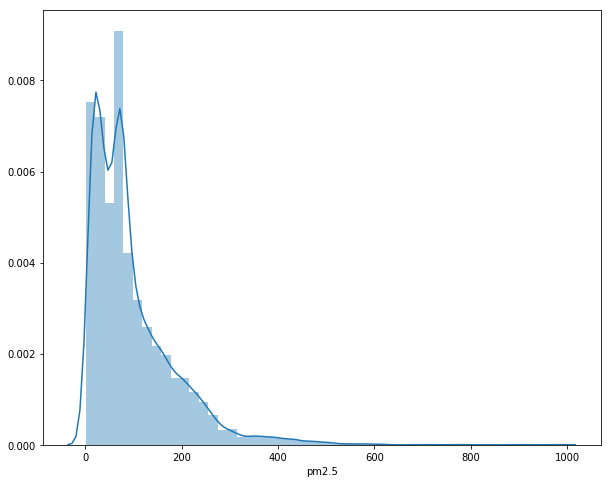

In [443]:
#check the distribution of plot
#SalePrice
sns.distplot(df_pollution['pm2.5'])
df_pollution['pm2.5'].skew()

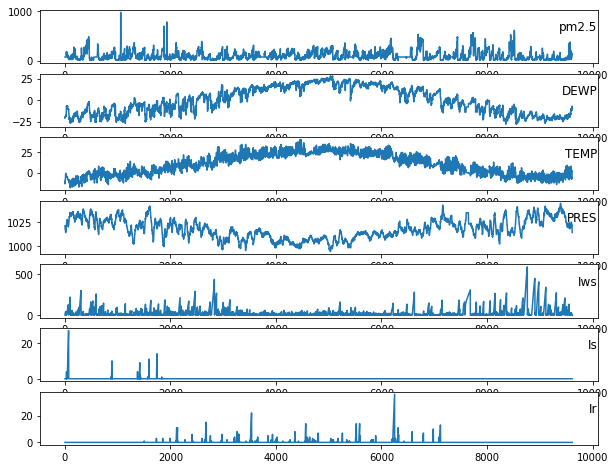

In [444]:
groups = [0, 1, 2, 3, 5, 6, 7]
values=df_pollution.values
i=1
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df_pollution.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [445]:
encoder = preprocessing.LabelEncoder()
df_pollution['cbwd'] = encoder.fit_transform(df_pollution['cbwd'])
df_pollution.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
Date,,,,,,,,
2010-01-01 00:00:00,73.0,-21.0,-11.0,1021.0,1,1.79,0.0,0.0
2010-01-01 01:00:00,73.0,-21.0,-12.0,1020.0,1,4.92,0.0,0.0
2010-01-01 02:00:00,73.0,-21.0,-11.0,1019.0,1,6.71,0.0,0.0
2010-01-01 03:00:00,73.0,-21.0,-14.0,1019.0,1,9.84,0.0,0.0
2010-01-01 04:00:00,73.0,-20.0,-12.0,1018.0,1,12.97,0.0,0.0


In [446]:
df_pollution=df_pollution.astype(float)
#check correlation among them 
corr=df_pollution.corr()
corr

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
pm2.5,1.000000,0.311605,0.111918,-0.301975,0.219806,-0.257389,-0.016561,-0.041342
DEWP,0.311605,1.000000,0.873586,-0.773200,0.277298,-0.308724,-0.034330,0.132312
TEMP,0.111918,0.873586,1.000000,-0.797325,0.232957,-0.209622,-0.087161,0.060501
PRES,-0.301975,-0.773200,-0.797325,1.000000,-0.245803,0.262257,0.044896,-0.060895
cbwd,0.219806,0.277298,0.232957,-0.245803,1.000000,-0.217496,0.025668,-0.055488
Iws,-0.257389,-0.308724,-0.209622,0.262257,-0.217496,1.000000,0.018548,-0.040995
Is,-0.016561,-0.034330,-0.087161,0.044896,0.025668,0.018548,1.000000,-0.009806
Ir,-0.041342,0.132312,0.060501,-0.060895,-0.055488,-0.040995,-0.009806,1.000000


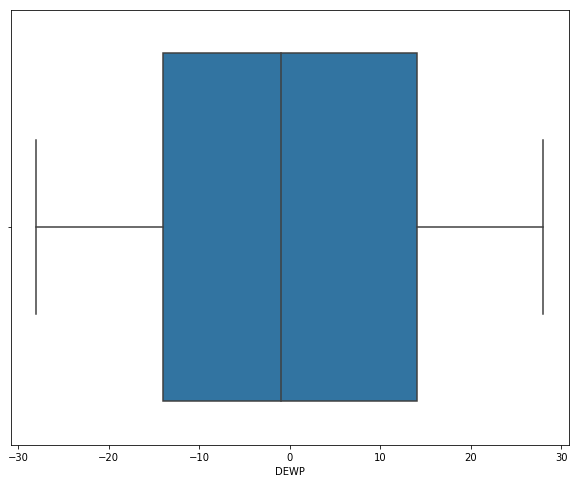

In [447]:
#GrLivArea variable
#check outlier
sns.boxplot(x=df_pollution['DEWP'])

In [448]:
#Removing outlier
print("before ",df_pollution.shape)
z = np.abs(stats.zscore(df_pollution))
threshold = 3
#print(np.where(z > 3))
#print(z[29][6])
#print("len of array ",len(np.where(z > 3)[0]))
#Remove column wise 
median_dewp=df_pollution.loc[df_pollution['DEWP']<600, 'DEWP'].median()
#median_dewp_log=np.log(median_dewp)
df_pollution["DEWP"]=np.where(df_pollution['DEWP']>600,median_dewp,df_pollution["DEWP"])
df_pollution[df_pollution['DEWP']>600]

('before ', (9616, 8))


,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
Date,,,,,,,,


In [449]:
#movingAverage(df_pollution)

In [450]:
df_pollution = df_pollution[(z < 3).all(axis=1)]

In [451]:
df_pollution.shape

(8966, 8)

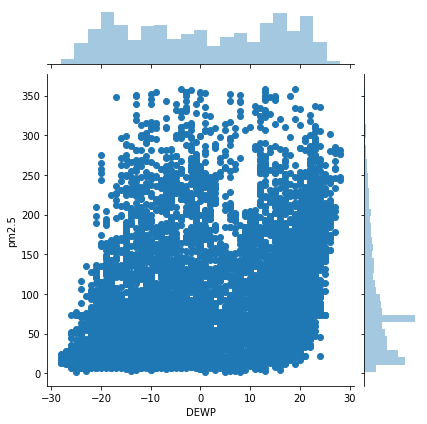

In [452]:
sns.jointplot(x=df_pollution['DEWP'], y=df_pollution['pm2.5'])

In [453]:
#df_pollution['pm2.5'] = np.log(df_pollution['pm2.5'])
#df_pollution['pm2.5'].skew()

In [454]:
corr['pm2.5'].sort_values(ascending=False)

pm2.5    1.000000
DEWP     0.311605
cbwd     0.219806
TEMP     0.111918
Is      -0.016561
Ir      -0.041342
Iws     -0.257389
PRES    -0.301975
Name: pm2.5, dtype: float64

In [455]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_pollution.iloc[:,0:])
scaled = scaler.transform(df_pollution.iloc[:,0:])
scaled=pd.DataFrame(scaled)

In [456]:
relevant_features = corr[corr['pm2.5']>0.5]
relevant_features

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
pm2.5,1.0,0.311605,0.111918,-0.301975,0.219806,-0.257389,-0.016561,-0.041342


In [457]:
#no of features
nof_list=np.arange(1,7)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
X=scaled.iloc[:,1:]
y=scaled.iloc[:,0]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 6
Score with 6 features: 0.342293


In [458]:
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 6)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Int64Index([1, 2, 3, 4, 5, 7], dtype='int64')


In [459]:
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# load the iris datasets
# fit an Extra Trees model to the data
X=df_pollution.iloc[:,1:]
y=df_pollution.iloc[:,0]
model = ExtraTreesClassifier()
model.fit(X, y)
# display the relative importance of each attribute
print(model.feature_importances_)

[0.20618774 0.22814532 0.21023276 0.02970601 0.31133398 0.00092
 0.01347419]


In [460]:
X=df_pollution.iloc[:,1:]
y=df_pollution.iloc[:,0]

In [461]:
X_train = X[:int(X.shape[0]*0.7)]
X_test = X[int(X.shape[0]*0.7):]
y_train = y[:int(X.shape[0]*0.7)]
y_test = y[int(X.shape[0]*0.7):]
y_test.head()

Date
2010-09-30 17:00:00     73.0
2010-09-30 18:00:00     73.0
2010-09-30 19:00:00     73.0
2010-09-30 20:00:00     73.0
2010-09-30 21:00:00    209.0
Name: pm2.5, dtype: float64

In [462]:
import xgboost as xgb
regr = xgb.XGBRegressor(colsample_bytree=0.2,
                       gamma=0.0,
                       learning_rate=0.05,
                       max_depth=6,
                       min_child_weight=1.5,
                       n_estimators=7200,
                       reg_alpha=0.9,
                       reg_lambda=0.6,
                       subsample=0.2,
                       seed=42,
                       silent=1)

regr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.2, gamma=0.0, importance_type='gain',
       learning_rate=0.05, max_delta_step=0, max_depth=6,
       min_child_weight=1.5, missing=None, n_estimators=7200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0.9,
       reg_lambda=0.6, scale_pos_weight=1, seed=42, silent=1,
       subsample=0.2)

In [463]:
from sklearn.metrics import mean_squared_error
def rmse(y_test,y_pred):
      return np.sqrt(mean_squared_error(y_test,y_pred))

# run prediction on training set to get an idea of how well it does
y_pred = regr.predict(X_test)
y_test = y_test
print("XGBoost score on training set: ", rmse(y_test, y_pred))
print(y_pred.shape)
print(y_test.shape)

('XGBoost score on training set: ', 64.96236789707716)
(2690L,)
(2690L,)


In [464]:
from sklearn.linear_model import Lasso

#found this best alpha through cross-validation
best_alpha = 0.00099

regr = Lasso(alpha=best_alpha, max_iter=50000)
regr.fit(X_train, y_train)

# run prediction on the training set to get a rough idea of how well it does
y_pred = regr.predict(X_test)
y_test = y_test
print("Lasso score on training set: ", rmse(y_test, y_pred))

('Lasso score on training set: ', 62.66422741635426)


In [465]:
#Anamoly detection
df_anamoly=pd.DataFrame()
#df_anamoly.reset_index()
df_anamoly['actuals']=y_test
df_anamoly['predicted']=y_pred
#df_anamoly.head()
#df_anamoly.rename({'Date':'load_date'})
df_anamoly['error']=df_anamoly['actuals']-df_anamoly['predicted']
df_anamoly['percentage_change'] = ((df_anamoly['actuals'] - df_anamoly['predicted']) / df_anamoly['actuals']) * 100
df_anamoly['meanval'] = df_anamoly['error'].rolling(window=7).mean()
df_anamoly['deviation'] = df_anamoly['error'].rolling(window=7).std()
df_anamoly['-3s'] = df_anamoly['meanval'] - (2 * df_anamoly['deviation'])
df_anamoly['3s'] = df_anamoly['meanval'] + (2 * df_anamoly['deviation'])
df_anamoly['-2s'] = df_anamoly['meanval'] - (1.75 * df_anamoly['deviation'])
df_anamoly['2s'] = df_anamoly['meanval'] + (1.75 * df_anamoly['deviation'])
df_anamoly['-1s'] = df_anamoly['meanval'] - (1.5 * df_anamoly['deviation'])
df_anamoly['1s'] = df_anamoly['meanval'] + (1.5 * df_anamoly['deviation'])
df_anamoly.tail(10)

,actuals,predicted,error,percentage_change,meanval,deviation,-3s,3s,-2s,2s,-1s,1s
Date,,,,,,,,,,,,
2011-02-05 06:00:00,82.0,137.715570,-55.715570,-67.945817,-67.239778,8.039595,-83.318968,-51.160588,-81.309069,-53.170486,-79.299170,-55.180385
2011-02-05 07:00:00,87.0,127.953113,-40.953113,-47.072544,-63.913672,12.860371,-89.634414,-38.192930,-86.419321,-41.408023,-83.204228,-44.623115
2011-02-05 08:00:00,90.0,98.809317,-8.809317,-9.788130,-55.157007,23.992103,-103.141212,-7.172802,-97.143186,-13.170828,-91.145161,-19.168853
2011-02-05 09:00:00,92.0,125.019180,-33.019180,-35.890413,-48.532629,22.544042,-93.620713,-3.444545,-87.984702,-9.080555,-82.348692,-14.716566
2011-02-05 10:00:00,97.0,118.680260,-21.680260,-22.350784,-41.275491,21.711375,-84.698241,2.147260,-79.270398,-3.280584,-73.842554,-8.708428
2011-02-05 11:00:00,100.0,127.113745,-27.113745,-27.113745,-35.265254,18.243877,-71.753008,1.222500,-67.192039,-3.338470,-62.631070,-7.899439
2011-02-05 12:00:00,105.0,118.249485,-13.249485,-12.618557,-28.648667,16.252012,-61.152691,3.855356,-57.089688,-0.207647,-53.026685,-4.270650
2011-02-05 13:00:00,109.0,111.446138,-2.446138,-2.244163,-21.038748,13.743766,-48.526280,6.448783,-45.090339,3.012842,-41.654397,-0.423100
2011-02-05 14:00:00,130.0,109.277070,20.722930,15.940715,-12.227885,17.969341,-48.166567,23.710797,-43.674231,19.218461,-39.181896,14.726126


In [466]:
z = np.abs(stats.zscore(df_pollution))
np.where(z>3)
#df_pollution.shape

(array([  27,   28,   32,   43,   44,   63,   64,   65,   66,   67,   68,
          69,   70,   71,   72,   73,   74,   75,  261,  262,  263,  264,
         265,  266,  267,  268,  369,  371,  375,  389,  390,  394,  396,
         397,  398,  400,  402,  403,  404,  405,  406,  436,  437,  438,
         471,  472,  473,  474,  475,  476,  525,  526,  527,  528,  529,
         530,  531,  532,  533,  534,  563,  674,  815,  825,  826,  831,
         990, 1240, 1242, 1246, 1247, 1304, 1305, 1318, 1339, 1340, 1343,
        1344, 1347, 1356, 1490, 1508, 1509, 1536, 1537, 1538, 1539, 1540,
        1541, 1594, 1646, 1647, 1648, 1649, 1738, 1756, 1757, 1784, 1790,
        1791, 1792, 1793, 1794, 1795, 1796, 1797, 1830, 1888, 1889, 2008,
        2008, 2009, 2010, 2016, 2017, 2018, 2019, 2059, 2060, 2061, 2062,
        2063, 2064, 2065, 2066, 2067, 2161, 2228, 2229, 2230, 2231, 2232,
        2233, 2293, 2294, 2295, 2296, 2331, 2332, 2333, 2334, 2335, 2336,
        2337, 2338, 2339, 2340, 2341, 

In [467]:
#Random Forest regressor to predict 5th and 7th column
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
#predicting for the 5th column
X=df_pollution.iloc[:,[0,1,2,3,4,6,7]]
y=df_pollution.iloc[:,5]
regressor.fit(X,y)
y_pred=regressor.predict(X)
y_pred[32]

19.008300000000006

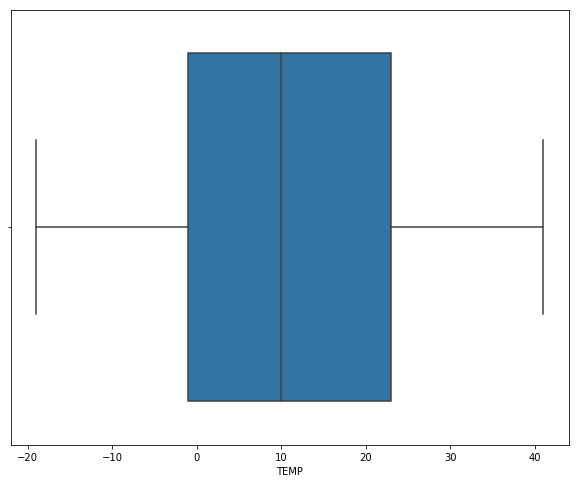

In [468]:
df_pollution.iloc[32,6]
sns.boxplot(x=df_pollution['TEMP'])

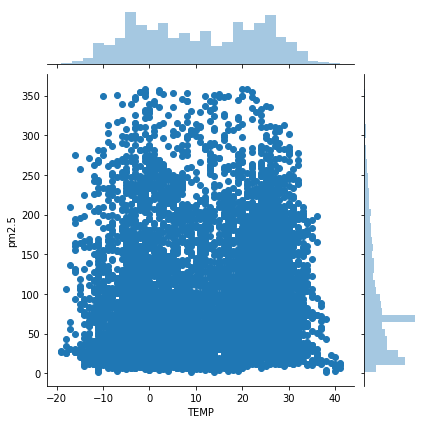

In [469]:
sns.jointplot(x=df_pollution['TEMP'], y=df_pollution['pm2.5'])

In [470]:
from sklearn import neighbors
from math import sqrt
rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

('RMSE value for k= ', 1, 'is:', 78.52276680723367)
('RMSE value for k= ', 2, 'is:', 72.20448103673613)
('RMSE value for k= ', 3, 'is:', 69.80533178283629)
('RMSE value for k= ', 4, 'is:', 68.6022950332494)
('RMSE value for k= ', 5, 'is:', 67.59599018045255)
('RMSE value for k= ', 6, 'is:', 67.05683903448615)
('RMSE value for k= ', 7, 'is:', 66.7942394756461)
('RMSE value for k= ', 8, 'is:', 66.62918708116327)
('RMSE value for k= ', 9, 'is:', 66.30211053155854)
('RMSE value for k= ', 10, 'is:', 65.82653963032391)
('RMSE value for k= ', 11, 'is:', 65.61301270927598)
('RMSE value for k= ', 12, 'is:', 65.38989161912066)
('RMSE value for k= ', 13, 'is:', 65.0620572029288)
('RMSE value for k= ', 14, 'is:', 65.03282882086766)
('RMSE value for k= ', 15, 'is:', 64.95169448983123)
('RMSE value for k= ', 16, 'is:', 64.83372334245936)
('RMSE value for k= ', 17, 'is:', 64.81021372348602)
('RMSE value for k= ', 18, 'is:', 64.71995669620634)
('RMSE value for k= ', 19, 'is:', 64.58092009564406)
('RMS

In [471]:
#DBScan method  #Scake the data first
from sklearn.cluster import DBSCAN
outlier_detection = DBSCAN(
 eps = .2, 
 metric="euclidean", 
 min_samples = 5,
 n_jobs = -1)
clusters = outlier_detection.fit_predict(df_pollution)
clusters
#pOint with -1 are outliers

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [472]:
cols = list(df_pollution.columns)
for col in cols:
    col_zscore = col + '_zscore'
    df_pollution[col_zscore] = (df_pollution[col] - df_pollution[col].mean())/df_pollution[col].std(ddof=0)
df_pollution

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,pm2.5_zscore,DEWP_zscore,TEMP_zscore,PRES_zscore,cbwd_zscore,Iws_zscore,Is_zscore,Ir_zscore
Date,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,73.0,-21.0,-11.0,1021.0,1.0,1.79,0.0,0.0,-0.261779,-1.388187,-1.650708,0.353277,-0.657138,-0.571426,-0.048837,-0.160689
2010-01-01 01:00:00,73.0,-21.0,-12.0,1020.0,1.0,4.92,0.0,0.0,-0.261779,-1.388187,-1.727172,0.255953,-0.657138,-0.493678,-0.048837,-0.160689
2010-01-01 02:00:00,73.0,-21.0,-11.0,1019.0,1.0,6.71,0.0,0.0,-0.261779,-1.388187,-1.650708,0.158628,-0.657138,-0.449215,-0.048837,-0.160689
2010-01-01 03:00:00,73.0,-21.0,-14.0,1019.0,1.0,9.84,0.0,0.0,-0.261779,-1.388187,-1.880102,0.158628,-0.657138,-0.371467,-0.048837,-0.160689
2010-01-01 04:00:00,73.0,-20.0,-12.0,1018.0,1.0,12.97,0.0,0.0,-0.261779,-1.321847,-1.727172,0.061303,-0.657138,-0.293719,-0.048837,-0.160689
2010-01-01 05:00:00,73.0,-19.0,-10.0,1017.0,1.0,16.10,0.0,0.0,-0.261779,-1.255506,-1.574243,-0.036022,-0.657138,-0.215971,-0.048837,-0.160689
2010-01-01 06:00:00,73.0,-19.0,-9.0,1017.0,1.0,19.23,0.0,0.0,-0.261779,-1.255506,-1.497778,-0.036022,-0.657138,-0.138222,-0.048837,-0.160689
2010-01-01 07:00:00,73.0,-19.0,-9.0,1017.0,1.0,21.02,0.0,0.0,-0.261779,-1.255506,-1.497778,-0.036022,-0.657138,-0.093759,-0.048837,-0.160689
2010-01-01 08:00:00,73.0,-19.0,-9.0,1017.0,1.0,24.15,0.0,0.0,-0.261779,-1.255506,-1.497778,-0.036022,-0.657138,-0.016011,-0.048837,-0.160689


In [504]:
df_pollution[df_pollution['pm2.5_zscore']>3]

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,pm2.5_zscore,DEWP_zscore,TEMP_zscore,PRES_zscore,cbwd_zscore,Iws_zscore,Is_zscore,Ir_zscore
Date,,,,,,,,,,,,,,,,
2010-01-17 21:00:00,317.0,-10.0,-7.0,1027.0,3.0,0.90,0.0,0.0,3.110747,-0.658441,-1.344848,0.937226,1.533973,-0.593534,-0.048837,-0.160689
2010-01-17 23:00:00,313.0,-12.0,-9.0,1027.0,0.0,0.89,0.0,0.0,3.055459,-0.791122,-1.497778,0.937226,-1.752693,-0.593782,-0.048837,-0.160689
2010-01-18 03:00:00,349.0,-13.0,-10.0,1028.0,1.0,6.71,0.0,0.0,3.553045,-0.857463,-1.574243,1.034551,-0.657138,-0.449215,-0.048837,-0.160689
2010-01-19 00:00:00,358.0,-4.0,-1.0,1025.0,1.0,1.79,0.0,0.0,3.677442,-0.260397,-0.886058,0.742577,-0.657138,-0.571426,-0.048837,-0.160689
2010-01-19 02:00:00,332.0,-5.0,-1.0,1024.0,1.0,6.71,0.0,0.0,3.318074,-0.326738,-0.886058,0.645252,-0.657138,-0.449215,-0.048837,-0.160689
2010-01-19 06:00:00,330.0,-4.0,-1.0,1021.0,1.0,12.07,0.0,0.0,3.290430,-0.260397,-0.886058,0.353277,-0.657138,-0.316074,-0.048837,-0.160689
2010-01-19 09:00:00,331.0,-4.0,0.0,1021.0,1.0,1.79,0.0,0.0,3.304252,-0.260397,-0.809593,0.353277,-0.657138,-0.571426,-0.048837,-0.160689
2010-01-19 10:00:00,323.0,-4.0,0.0,1021.0,3.0,0.89,0.0,0.0,3.193678,-0.260397,-0.809593,0.353277,1.533973,-0.593782,-0.048837,-0.160689
2010-01-19 11:00:00,339.0,-5.0,1.0,1021.0,1.0,1.79,0.0,0.0,3.414827,-0.326738,-0.733129,0.353277,-0.657138,-0.571426,-0.048837,-0.160689


In [473]:
#LSTM model for timeseries prediction
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dataset = df_pollution
values = dataset.values
#integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ImportError: cannot import name np_utils